# Twitter sentiment analysis
##### The aim of the project is to predict the sentiment (positive/negative) of tweets, with the help of separate words, and their connections. 
##### Around 1.6 million tweets are to be analysed. Such program can be used by political agencies, advertising companies, or other.

### ABOUT THE DATASET 
#### The dataset consists of 1.6 million tweet, usually in a form of a sentence, or a few of them. The other parts, for example user ID, or the date of creating the tweet are also present, however they will be deleted soon.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin-1')
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


## Data pre-preprocessing

#### Here, only the sentiment of the tweet and the text are left, however if the separate words are to be investigated, the things such as punctuation marks should be deleted

In [2]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.loc[df['sentiment'] == 4, 'sentiment'] = 1
df.head()

,sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


# Natural language processing (stopwords removal and Lemmatization)  
### There are some words, such as "to", "a", "The", so-called "stopwords", which should not be used in finding the sentiment of the tweet, they should be deleted.

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### There is also an idea of lemmatization - changing all words from one "family" into one root word.

In [4]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
import re
def preprocess(text):
    text = re.sub("@\S+|https?:\S+|http?:\S|\w*\d\w*|[^A-Za-z0-9]+|www?:\S", ' ', str(text).lower())
    text = text.strip()
    tokens = []
    tokens_not_lemma = []
    for word in text.split():
        if word not in stop_words:
            tokens_not_lemma.append(word)
            if lemmatizer.lemmatize(word) != word: #checks whether stemming is possible
                tokens.append(lemmatizer.lemmatize(word))
            else:
                tokens.append(word)
    return " ".join(tokens)

### Now the tweets are much more better for the computer to analyze

In [6]:
df.text = df.text.apply(lambda x: preprocess(x))
df.head()

,sentiment,text
0,0,upset update facebook texting might cry result...
1,0,dived many time ball managed save rest go bound
2,0,whole body feel itchy like fire
3,0,behaving mad see
4,0,whole crew


### Let's also see the most often occuring words in both positive and negative tweets

In [7]:
positive_tweets = df[df.sentiment == 1]
negative_tweets = df[df.sentiment == 0]

Text(0.5, 1.0, 'Top 15 Most Occurring Words in Positive Tweets')

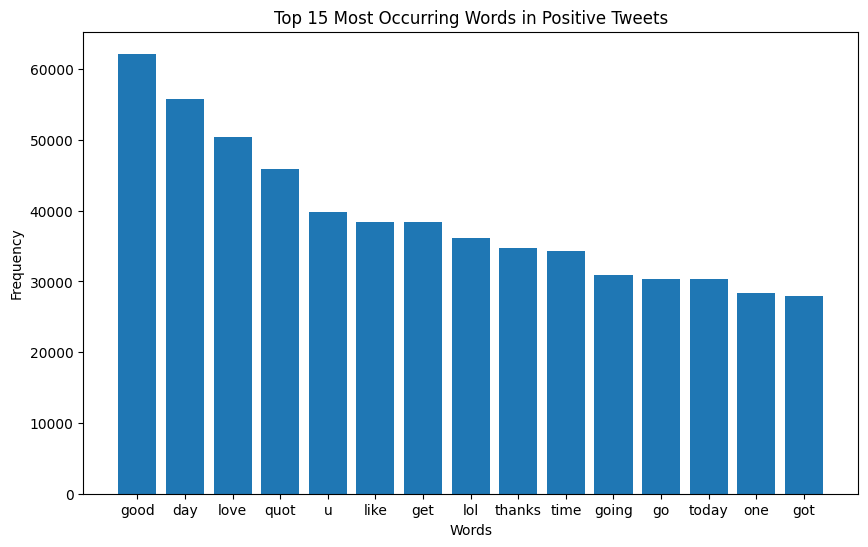

In [8]:
from collections import Counter 
pos_words = " ".join(positive_tweets.text)
pos_words = pos_words.split() 
pos_words_freq = Counter(pos_words)

most_occur = pos_words_freq.most_common(15) 
words, frequencies = zip(*most_occur)
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Occurring Words in Positive Tweets')


Text(0.5, 1.0, 'Top 15 Most Occurring Words in negative Tweets')

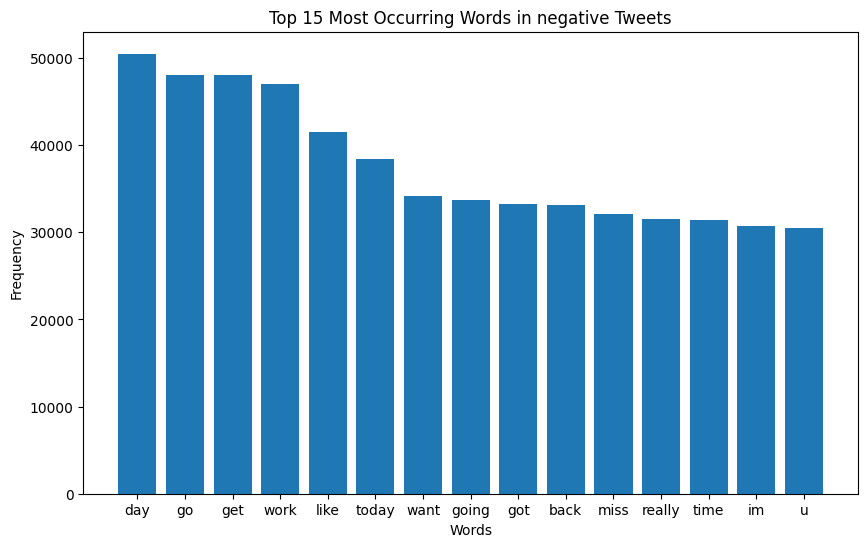

In [9]:
neg_words = " ".join(negative_tweets.text)
neg_words = neg_words.split() 

neg_words_freq = Counter(neg_words)
most_occur2 = neg_words_freq.most_common(15)
words2, frequencies2 = zip(*most_occur2)
plt.figure(figsize=(10, 6))
plt.bar(words2, frequencies2)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Occurring Words in negative Tweets')

### Some of them like "good", "love", "miss" are to be expected, but there is also a lot of words with no apparent sentiment

### Now, let's build a model using Tfidf-Vectorizer - meaning we will build the vectors from our train part of data (later, we will use the downloaded vectors)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer(max_features=1000000000)
X = tfidf_vectorizer.fit_transform(df['text'])
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

### Building first model: Logistic regression

#### After some testing, the most effective parameters have been found

In [25]:

'''
from sklearn.model_selection import GridSearchCV


model = LogisticRegression()
###used to find the best parameters
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 300, 1000]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Score:", test_score)'''


'\nfrom sklearn.model_selection import GridSearchCV\n\n\nmodel = LogisticRegression()\n###used to find the best parameters\nparam_grid = {\n    \'penalty\': [\'l1\', \'l2\'],\n    \'C\': [0.001, 0.01, 0.1, 1, 10, 100],\n    \'solver\': [\'liblinear\', \'newton-cg\', \'lbfgs\', \'sag\', \'saga\'],\n    \'max_iter\': [100, 300, 1000]\n}\n\ngrid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)\ngrid_search.fit(X_train, y_train)\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\nprint("Best Parameters:", best_params)\nprint("Best Score:", best_score)\nbest_model = grid_search.best_estimator_\ntest_score = best_model.score(X_test, y_test)\nprint("Test Score:", test_score)'

In [27]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'liblinear', max_iter= 1000)
model1.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

### And let's also compare it with a most default naive bayes model

In [28]:
from sklearn.naive_bayes import MultinomialNB
model2 = MultinomialNB(alpha=0.1)
model2.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

### We can also see now, what are the words that make tweets' sentiments negative or positive, at least according to tfidf-vectorizer

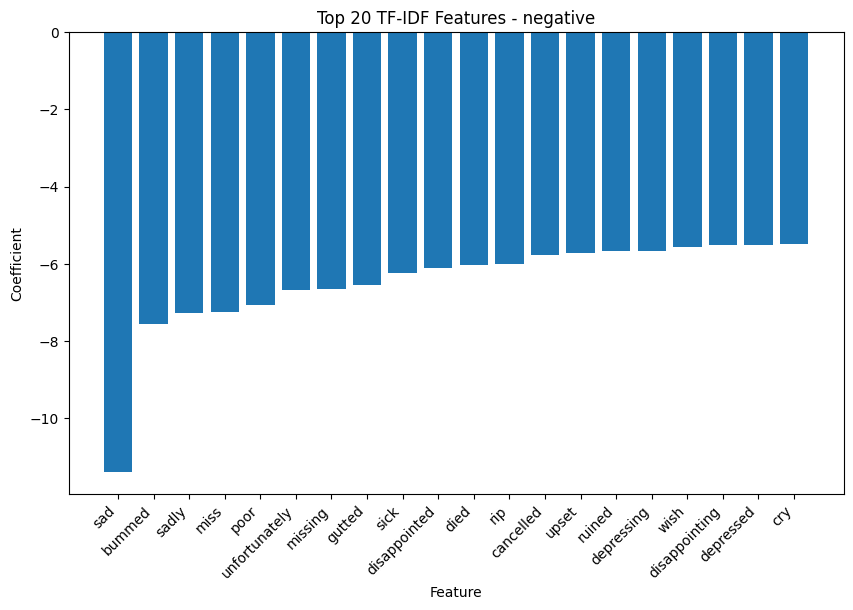

In [29]:

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model1.coef_.flatten()

#Create a df to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=True)

#Display top 20 most important features
top_features = feature_importance_df.head(20)  # Adjust N as needed
plt.figure(figsize=(10, 6))
plt.bar(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 20 TF-IDF Features - negative')
plt.xticks(rotation=45, ha='right')
plt.show()

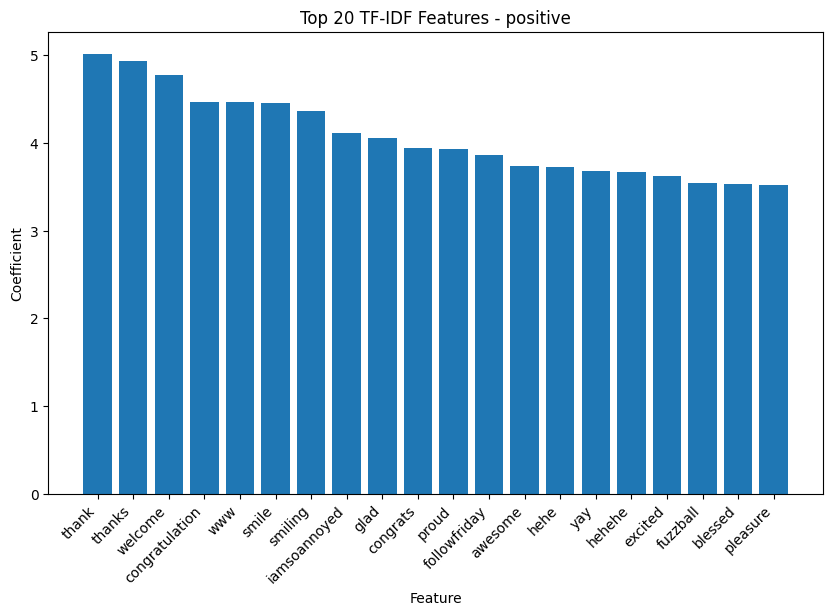

In [30]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model1.coef_.flatten()

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=False)

top_features = feature_importance_df.head(20) 
plt.figure(figsize=(10, 6))
plt.bar(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 20 TF-IDF Features - positive')
plt.xticks(rotation=45, ha='right')
plt.show()

### Some confusion matrices and checking of the results

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = model1.predict(X_test)
accuracy1 = accuracy_score(y_test, y_pred)

print(f'Accuracy - logistic regression: {accuracy1:.2f}')

print(classification_report(y_test, y_pred))
conf_matrix1 = confusion_matrix(y_test, y_pred)

Accuracy - logistic regression: 0.78
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159911
           1       0.77      0.80      0.78    160089

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [32]:
y_pred2 = model2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)

print(f'Accuracy - Naive bayes: {accuracy2:.2f}')

print(classification_report(y_test, y_pred2))
conf_matrix2 = confusion_matrix(y_test, y_pred2)

Accuracy - Naive bayes: 0.75
              precision    recall  f1-score   support

           0       0.75      0.77      0.76    159911
           1       0.76      0.74      0.75    160089

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



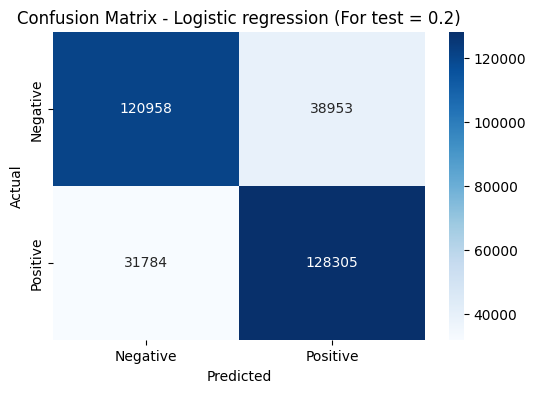

In [33]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic regression (For test = 0.2)')
plt.show()

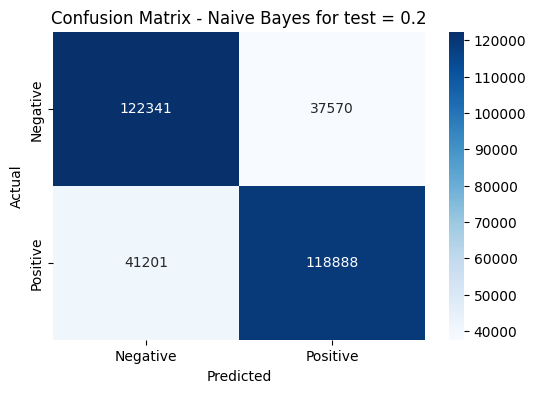

In [34]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes for test = 0.2')
plt.show()

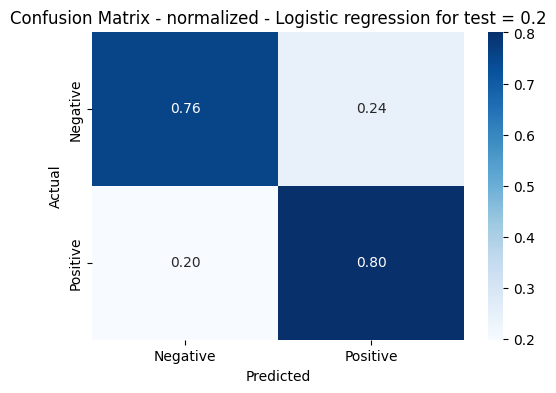

In [35]:
#creating a normalised matrix
conf_matrix1_normalised = conf_matrix1.astype('float') / conf_matrix1.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix1_normalised, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - normalized - Logistic regression for test = 0.2')
plt.show()

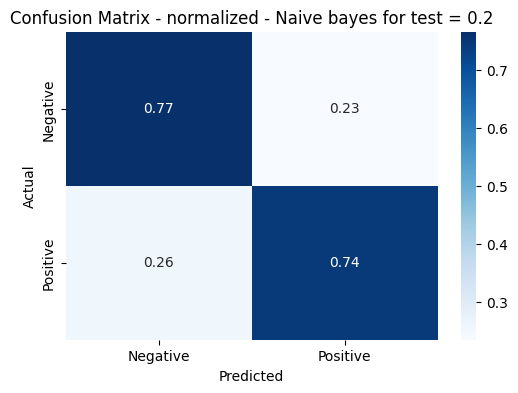

In [36]:
conf_matrix2_normalised = conf_matrix2.astype('float') / conf_matrix2.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix2_normalised, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - normalized - Naive bayes for test = 0.2')
plt.show()

### Instead of tfidf, one can also use prebuilt vectors, such as word2vec and glove, it would be an interesting idea to check if they are better or not than our built matrix

### WORD2VEC

In [37]:
import gensim.downloader as api
word_vectors = api.load('word2vec-google-news-300')

In [38]:
def get_tweet_vector(tweet):
    words = [word for word in tweet.split() if word in word_vectors]
    if not words:
        return np.zeros(300)  #vectors have 300 dimensions
    return np.mean(word_vectors[words], axis=0)

features = np.array([get_tweet_vector(tweet) for tweet in df['text']])

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=9)

# Step 3: Create and train the logistic regression model
model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'liblinear', max_iter= 1000)
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy3}')
print(classification_report(y_test, y_pred))

Accuracy: 0.7283375
              precision    recall  f1-score   support

           0       0.73      0.71      0.72    159911
           1       0.72      0.74      0.73    160089

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000



### GLOVE

In [39]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
glove_file = 'glove.6B.300d.txt'  
word2vec_output_file = 'twitter.27B.300d.word2vec'
glove2word2vec(glove_file, word2vec_output_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

C:\Users\julek\AppData\Local\Temp\ipykernel_1676\1994433659.py:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_output_file)


In [40]:
def get_tweet_vector(tweet):
    words = [word for word in tweet.split() if word in word_vectors]
    if not words:
        return np.zeros(300)
    return np.mean(word_vectors[words], axis=0)

features = np.array([get_tweet_vector(tweet) for tweet in df['text']])

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=9)

model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'liblinear', max_iter= 1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy4 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy4}')
print(classification_report(y_test, y_pred))

Accuracy: 0.71489375
              precision    recall  f1-score   support

           0       0.72      0.71      0.71    159911
           1       0.71      0.72      0.72    160089

    accuracy                           0.71    320000
   macro avg       0.71      0.71      0.71    320000
weighted avg       0.71      0.71      0.71    320000



### Tfidf - vectorizer seems to be better

### Logistic regression has given us some very promising results, however, neural networks could be even better

### LSTM 

### Let's start from scratch with the split of train and test data

In [41]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
train_data, test_data = train_test_split(df, test_size=0.2,
                                         random_state=9)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index

vocab_size = len(tokenizer.word_index) + 1
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = 20)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = 20)

print("Vocabulary Size :", vocab_size)
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)


Vocabulary Size : 258842
Training X Shape: (1279999, 20)
Testing X Shape: (320000, 20)


In [42]:
labels = train_data.sentiment.unique().tolist()

In [43]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1279999, 1)
y_test shape: (320000, 1)


In [44]:
EMBEDDING_DIM = 300
LR = 1e-3 #could be changed

### Adding an embedding layer to our long short term memory

In [45]:
import tensorflow as tf
embedding_layer = tf.keras.layers.Embedding(
    vocab_size,
    EMBEDDING_DIM,
    input_length=20,
    trainable=True  #Allow the model to update the embeddings during training
)

# Training - LSTM

### Cell of LSTM

In [46]:
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
sequence_input = Input(shape=(20,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [47]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)


### Increasing the batch size will decrease the accuracy

In [50]:
BATCH_SIZE = 512 #more -> overfitting, less -> incredibly long time
EPOCHS = 1 #more -> overfitting and incredibly long time
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

2500/2500 [==============================] - 2693s 1s/step - loss: 0.3038 - accuracy: 0.8655 - val_loss: 0.5307 - val_accuracy: 0.7767 - lr: 0.0010


In [52]:
if EPOCHS > 1:
    s, (at, al) = plt.subplots(2,1)
    at.plot(history.history['accuracy'], c= 'b')
    at.plot(history.history['val_accuracy'], c='r')
    at.set_title('model accuracy')
    at.set_ylabel('accuracy')
    at.set_xlabel('epoch')
    at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

    al.plot(history.history['loss'], c='m')
    al.plot(history.history['val_loss'], c='c')
    al.set_title('model loss')
    al.set_ylabel('loss')
    al.set_xlabel('epoch')
    al.legend(['train', 'val'], loc = 'upper left')
    #useful only when more than 1 epoch

In [53]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0
scores = model.predict(x_test, verbose=1, batch_size=10024)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 19s 586ms/step


In [54]:
accuracynlp = accuracy_score(y_test, y_pred_1d)
print(f'Accuracy - nlp: {accuracynlp:.2f}')
print(classification_report(y_test, y_pred_1d))
conf_matrixnlp = confusion_matrix(y_test, y_pred_1d)

Accuracy - nlp: 0.78
              precision    recall  f1-score   support

           0       0.78      0.77      0.78    159911
           1       0.77      0.78      0.78    160089

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



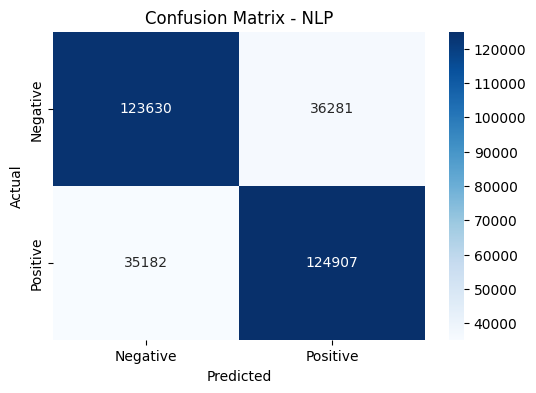

In [55]:

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrixnlp, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - NLP')
plt.show()

In [56]:
report = classification_report(list(test_data.sentiment), y_pred_1d)
print(report)
accuracy6 = accuracy_score(list(test_data.sentiment), y_pred_1d)

              precision    recall  f1-score   support

           0       0.78      0.77      0.78    159911
           1       0.77      0.78      0.78    160089

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



# 9. COMPARISON

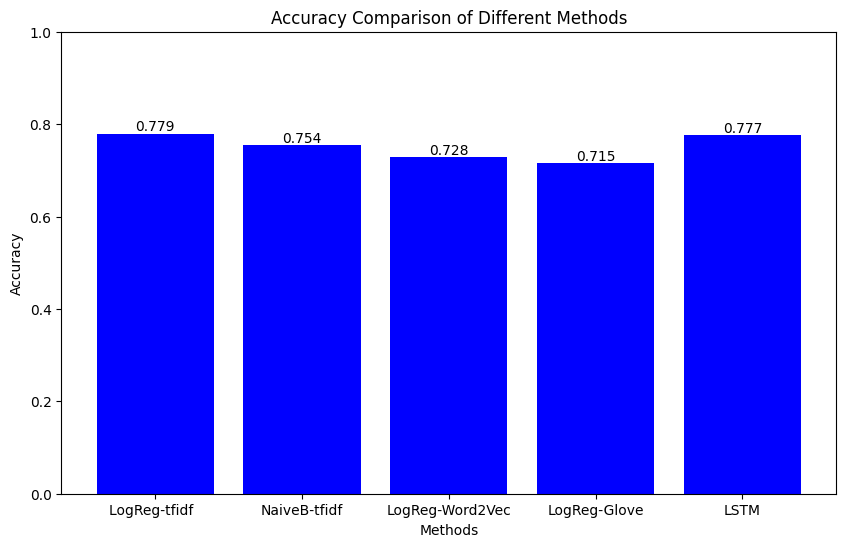

In [57]:
methods = ['LogReg-tfidf  ', 'NaiveB-tfidf', 'LogReg-Word2Vec', 'LogReg-Glove', 'LSTM']



accuracy_values = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy6]


plt.figure(figsize=(10, 6))

plt.bar(methods, accuracy_values, color='blue')
plt.ylim(0, 1) 
plt.title('Accuracy Comparison of Different Methods')

plt.xlabel('Methods')
plt.ylabel('Accuracy')
for i, value in enumerate(accuracy_values):
    plt.text(i, value, round(value,3), ha='center', va='bottom')
plt.show()